In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
from pathlib import Path
import sys 
CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))
from src.utils.common.isotope import Radionuclide_lara

In [3]:
df = pd.read_csv("rn.csv", sep=";")
# modify the format of the Radionuclide name : change 54Mn to Mn-54 for example
df["Radionuclide"] = df["Radionuclide"].apply(lambda x: f"{''.join(filter(str.isalpha, x))}-{''.join(filter(str.isdigit, x))}")

In [ ]:
dict_rn = df.set_index("Radionuclide").to_dict()["Mass[g]"]

In [5]:
dict_rn

{'Mn-54': 0.0002,
 'Co-58': 0.0003,
 'Co-60': 0.0005,
 'Fe-59': 0.0001,
 'Cr-51': 0.0004,
 'Co-57': 0.0002,
 'Zn-65': 0.0001,
 'Fe-55': 0.0002,
 'Mn-56': 0.0003,
 'Na-22': 0.0001}

In [6]:
def compute_total_source_term(dict_rn, time: int = 0, unit_energy: str = "keV") -> tuple:
    """
    Compute the total photon emission spectrum for a set of radionuclides.

    Parameters:
        dict_rn (dict): Dictionary of radionuclide names and their masses.
        time (int): Time in seconds after which to compute the activity.
        unit_energy (str): Energy unit for output rays ("keV", "MeV", or "eV").

    Returns:
        rays (np.ndarray): Array of photon energies.
        weights (np.ndarray): Corresponding weighted intensities.
        total_weight (float): Sum of all weights.
    """
    rays = []
    weights = []
    for rn, mass in dict_rn.items():
        rn_lara = Radionuclide_lara(rn)
        energy, intensity, _ = rn_lara.get_rays_emission_data(photon_only=True)
        activity = rn_lara.get_activity_after_time(mass=mass, time=time)
        rays.extend(energy)
        weights.extend(intensity * activity)
    rays = np.array(rays)
    weights = np.array(weights)
    if unit_energy == "keV":
        pass
    elif unit_energy == "MeV":
        rays = rays / 1000
    elif unit_energy == "eV":
        rays = rays * 1000
    total_weight = np.sum(weights)
    return rays, weights, total_weight

Calcul du terme source après 0 seconde

In [7]:
rays, weights, total_weight = compute_total_source_term(dict_rn, time=0, unit_energy="MeV")

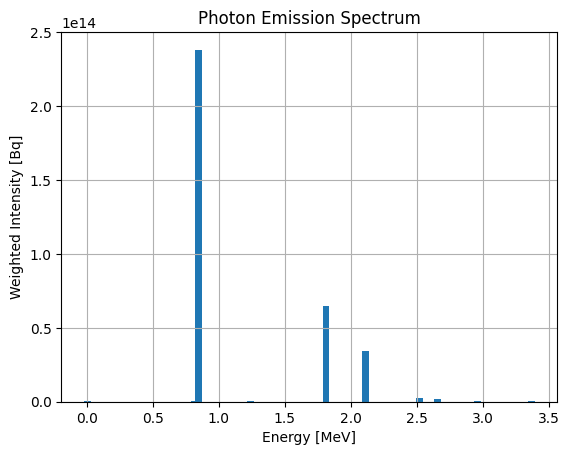

In [8]:
plt.bar(rays, weights, width=0.05)
plt.xlabel("Energy [MeV]")
plt.ylabel("Weighted Intensity [Bq]")
plt.title("Photon Emission Spectrum")
plt.grid(True)
plt.show()

In [9]:
rays, weights, total_weight = compute_total_source_term(dict_rn, time=3600*24*7, unit_energy="MeV")

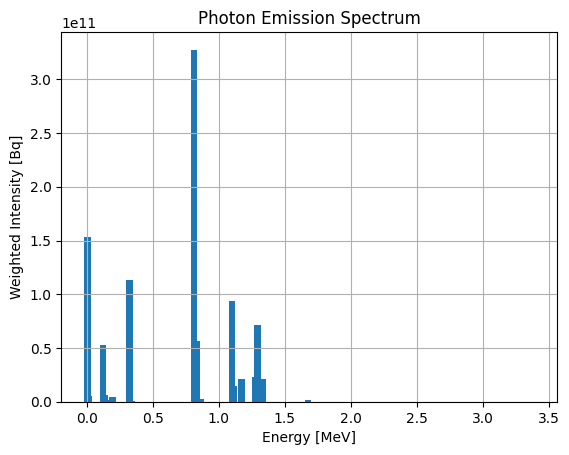

In [10]:
plt.bar(rays, weights, width=0.05)
plt.xlabel("Energy [MeV]")
plt.ylabel("Weighted Intensity [Bq]")
plt.title("Photon Emission Spectrum")
plt.grid(True)
plt.show()

Caclcul of the activity after several points of time

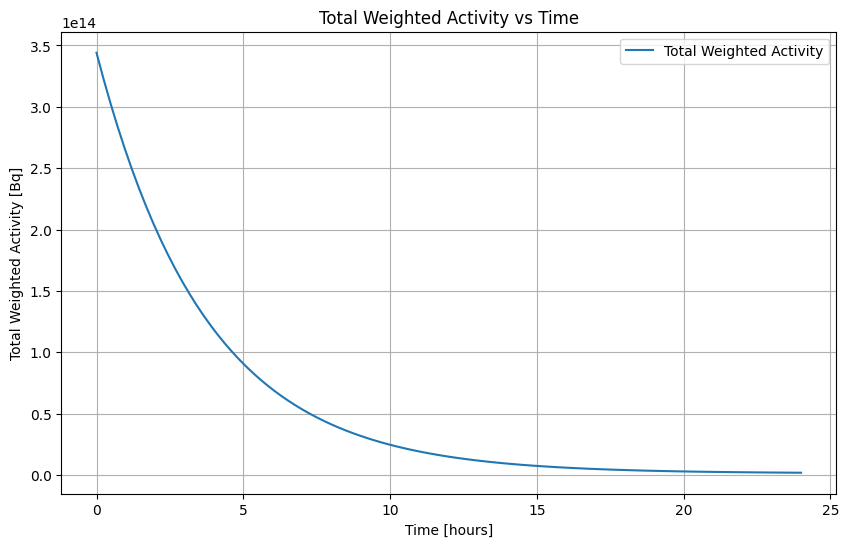

In [11]:
time_points = np.linspace(0, 3600 * 24, 100)  # 1 day in seconds
def compute_total_activity(dict_rn, time_points):
    total_weight_at_time = []
    for time in time_points:
        _, _, total_weight = compute_total_source_term(dict_rn, time=time)
        total_weight_at_time.append(total_weight)
    return total_weight_at_time

total_weight_at_time = compute_total_activity(dict_rn, time_points)

plt.figure(figsize=(10, 6))
plt.plot(time_points / 3600, total_weight_at_time, label="Total Weighted Activity")
plt.xlabel("Time [hours]")
plt.ylabel("Total Weighted Activity [Bq]")
plt.title("Total Weighted Activity vs Time")
plt.legend()
plt.grid(True)
plt.show()

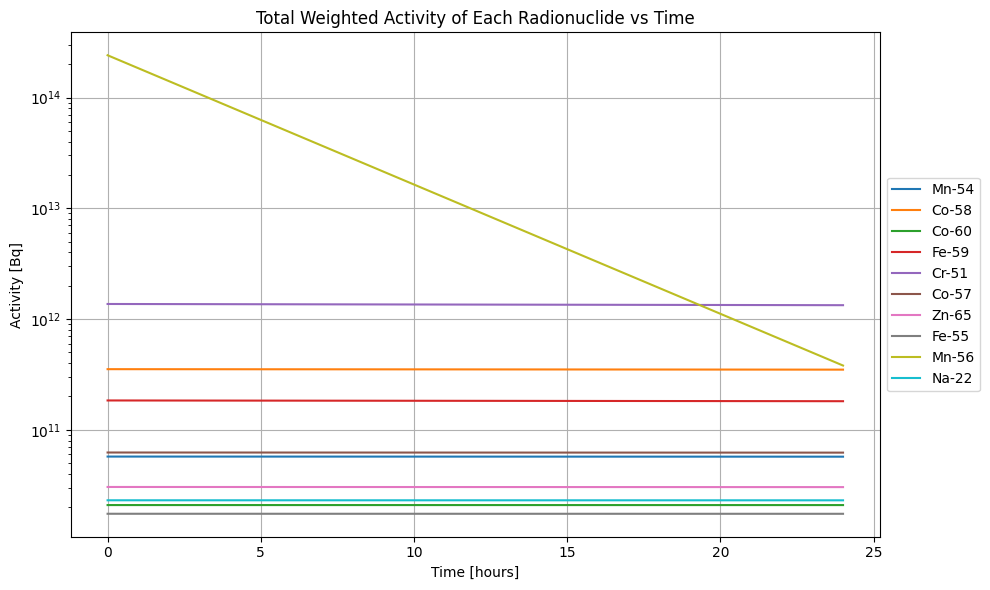

In [12]:
# plot the total weighted activity of every radionuclide vs time
# Calculate and plot the total weighted activity of every radionuclide vs time

time_points = np.linspace(0, 3600 * 24, 100)  # 1 day in seconds
total_weights_per_rn = {}
for rn, mass in dict_rn.items():
    rn_lara = Radionuclide_lara(rn)
    # Compute activity at each time point for this radionuclide
    activities = np.array([rn_lara.get_activity_after_time(mass=mass, time=t) for t in time_points])
    total_weights_per_rn[rn] = activities

plt.figure(figsize=(10, 6))
for rn, activities in total_weights_per_rn.items():
    plt.plot(time_points / (3600), activities, label=rn)
plt.xlabel("Time [hours]")
plt.ylabel("Activity [Bq]")
plt.title("Total Weighted Activity of Each Radionuclide vs Time")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

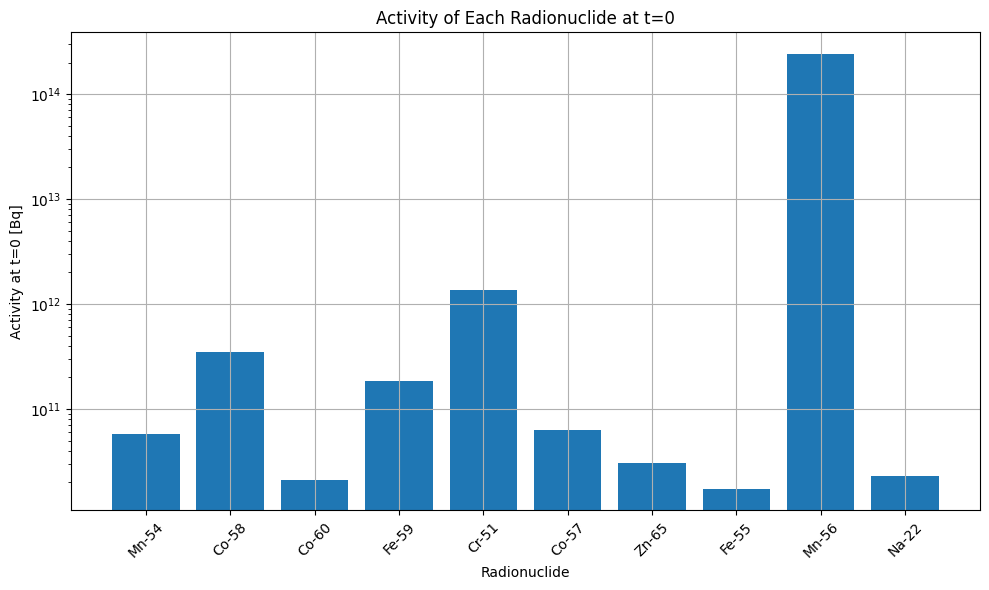

In [ ]:
# plot an histogramn of the activity of every radionuclide at t=0

def plot_activities_per_rn(dict_rn, time=0):
    """
    Calculate and plot the activity of each radionuclide at a given time.

    Parameters:
        dict_rn (dict): Dictionary of radionuclide names and their masses.
        time (float): Time in seconds at which to calculate the activity.
    """
    activities_at_time = {}
    for rn, mass in dict_rn.items():
        rn_lara = Radionuclide_lara(rn)
        activity = rn_lara.get_activity_after_time(mass=mass, time=time)
        activities_at_time[rn] = activity

    plt.figure(figsize=(10, 6))
    plt.bar(activities_at_time.keys(), activities_at_time.values())
    plt.xlabel("Radionuclide")
    plt.ylabel(f"Activity at t={time} [Bq]")
    plt.title(f"Activity of Each Radionuclide at t={time}")
    plt.yscale("log")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_activities_per_rn(dict_rn, time=0)

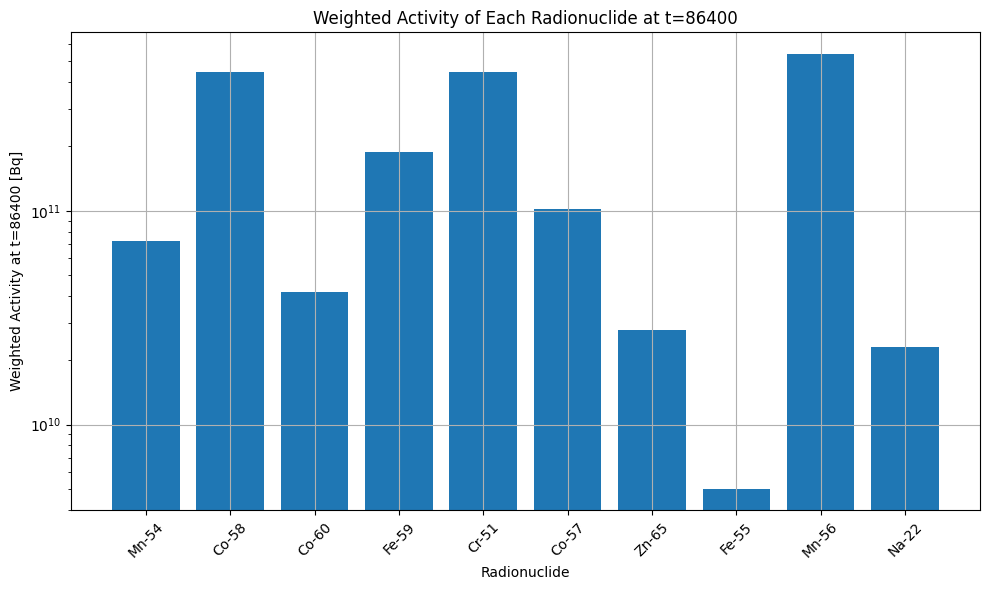

In [17]:
def plot_weighted_activities_per_rn(dict_rn, time=0):
    """
    Calculate and plot the weighted activity (total photon emission) of each radionuclide at a given time.

    Parameters:
        dict_rn (dict): Dictionary of radionuclide names and their masses.
        time (float): Time in seconds at which to calculate the weighted activity.
    """
    weighted_activities = {}
    for rn, mass in dict_rn.items():
        rn_lara = Radionuclide_lara(rn)
        energy, intensity, _ = rn_lara.get_rays_emission_data(photon_only=True)
        activity = rn_lara.get_activity_after_time(mass=mass, time=time)
        weighted_activity = np.sum(intensity * activity)
        weighted_activities[rn] = weighted_activity

    plt.figure(figsize=(10, 6))
    plt.bar(weighted_activities.keys(), weighted_activities.values())
    plt.xlabel("Radionuclide")
    plt.ylabel(f"Weighted Activity at t={time} [Bq]")
    plt.title(f"Weighted Activity of Each Radionuclide at t={time}")
    plt.yscale("log")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_weighted_activities_per_rn(dict_rn, time=3600*24)

In [15]:
def penalizing_source_term(rays, weights, energy_min:float = 0.0, energy_max:float = 3.0, energy_width:float = 0.5):
    """
    Aggregate rays and weights into specified energy windows.

    Parameters:
        rays (np.ndarray): Array of ray energies.
        weights (list or np.ndarray): Corresponding weights for each ray.
        energy_min (float): Minimum energy for the first window.
        energy_max (float): Maximum energy for the last window.
        energy_width (float): Width of each energy window.

    Returns:
        window_energies (list): Energy of the highest-energy ray in each window.
        window_weights (list): Sum of weights in each window.
    """
    rays = np.array(rays)
    weights = np.array(weights)
    bins = np.arange(energy_min, energy_max, energy_width)
    energy_windows = [(emin, emin + energy_width) for emin in bins]
    window_energies = []
    window_weights = []
    for (emin, emax) in energy_windows:
        mask = (rays >= emin) & (rays < emax)
        if np.any(mask):
            max_energy = rays[mask].max()
            sum_weight = weights[mask].sum()
            window_energies.append(max_energy)
            window_weights.append(sum_weight)
    return window_energies, window_weights

# Example usage:
window_energies, window_weights = penalizing_source_term(rays, weights, energy_min=0, energy_max=3.0, energy_width=0.5)
print("Window energies:", window_energies)
print("Window weights:", window_weights)

Window energies: [np.float64(0.38245999999999997), np.float64(0.863958), np.float64(1.4817), np.float64(1.810726), np.float64(2.15857), np.float64(2.95992)]
Window weights: [np.float64(612212670512.5681), np.float64(386355537963.51984), np.float64(244341410467.62012), np.float64(1739040324.9323347), np.float64(250312.35914086422), np.float64(417.18726535082465)]


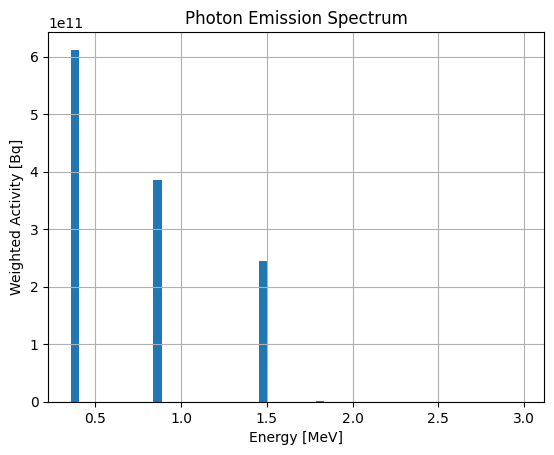

In [16]:
plt.bar(window_energies, window_weights, width=0.05)
plt.xlabel("Energy [MeV]")
plt.ylabel("Weighted Activity [Bq]")
plt.title("Photon Emission Spectrum")
plt.grid(True)
plt.show()